In [45]:
import os

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [46]:
#Определяем рабочий файл - формата mpt

def read_mpt(filepath):
    """
    Takes full filepath to .mpt file, and returns dataframe for this experiment
    Args:
        filepath (str):

    Returns:
        pd.Dataframe
    """
    #Находим количество строк, которые нужно игнорировать
    with open(filepath, 'r', encoding='mbcs', ) as f:
        for i in range(100):
            line = f.readline()
            if 'Nb header lines' in line:
                header_lines = int(line.split()[-1])
    skip_rows = header_lines - 1
    print(f'skip {skip_rows} rows')

    #Получаем данные из файла
    raw_data = pd.read_csv(filepath, encoding='mbcs', skiprows=skip_rows, sep='\t')
    return raw_data


def import_ocv(raw_data, gs_sequences, relax_sequences, Q0=0):
    #Сделать группировку по методикам - Ns номеру кривой.
    agg_data = raw_data.groupby((raw_data["Ns"] != raw_data["Ns"].shift()).cumsum())
    #Нужно указать, какие номера методик Ns соответствуют гальваностатике и зарядке, а какие - релаксации. Из первых методик берётся последнее значение dQ в группе, из второго - последнее значение E в группе.

    #Извлекает итоговые результаты напряжения и количества тока, пересчитывает в интегральное количество
    last_values = agg_data.last()
    E = last_values[last_values['Ns'].isin(relax_sequences)].reset_index(drop=True)['Ewe/V']
    dQ = last_values[last_values['Ns'].isin(gs_sequences)].reset_index(drop=True)['dQ/mA.h']
    Q = pd.concat([pd.Series(Q0), dQ]).reset_index(drop=True).cumsum()
    ocv_curve = pd.concat([E, Q], axis=1)
    return ocv_curve


def group_sequences(data, column='Ns'):
    #Return grouper with sequential elements by value
    return data.groupby((data[column] != data[column].shift()).cumsum())


def differ(data):
    grouped = group_sequences(data)
    diff = grouped.last() - grouped.first()
    diff.rename(columns={'E': 'dE', 't': 'dt'}, inplace=True)
    diff['Ns'] = grouped.max()['Ns']
    diff['E'] = grouped.mean()['E']
    diff['t'] = grouped.min()['t']
    return diff


def plot_eDe(diff, ns=[3]):
    diff[diff['Ns'].isin(ns)].plot(x='E', y='dE')


def plot_dt(diff, ns=[3]):
    diff[diff['Ns'].isin(ns)].plot(x='E', y='dt')


def plot_dq(diff, ns=[2]):
    diff[diff['Ns'].isin(ns)].plot(y='dQ', x='E')


In [191]:
def relax1(x, a, b, c):
    return a * np.exp(-x / b) + c


def relax2(x, a, b, d, f, c):
    return a * np.exp(-x / b) + d * np.exp(-x / f) + c


def relax3(x, a, b, d, f, g, h, c):
    return a * np.exp(-x / b) + d * np.exp(-x / f) + g * np.exp(-x / h) + c


def relax_polynom(x, a, b, d, f, c):
    return c + (a * x + b) / (np.square(x) + d * x + f)


def relax_cotrell(x, a, b, c):
    return c + a / np.sqrt(x + b)

In [48]:
def fit_e(raw_file, grouped, idxs, func_couple, **kwargs):
    func = func_couple[0]
    init = func_couple[1:]
    results = []
    for i in idxs:
        idx = grouped.groups[i]
        t = raw_file.loc[idx]['t']
        t = t - t.min()
        E = raw_file.loc[idx]['E']
        E = E.reset_index(drop=True)
        t = t.reset_index(drop=True)
        tE = pd.concat([t, E], axis=1).to_numpy()
        solution, _ = curve_fit(func, tE[:, 0], tE[:, 1], init, maxfev=10000, **kwargs)
        (np.square(func(t, *solution) - E)).plot()
        loss = np.sqrt(np.sum(np.square(func(t, *solution) - E) / len(E)))
        res = np.hstack([solution, loss])
        results.append(res)
    return np.vstack(results)

**Здесь начинается работа с файлами!**


In [192]:
filedir = r"D:\!Science\Analysis\Electrochem\Nissan\2023 12 20 additional experiments\DVA processing\8.2"

In [193]:
files = [i for i in os.listdir(filedir) if '.mpt' in i]
files

['2024 01 08 D14 refilled DV charge mid_C11.mpt',
 '2024 01 10 D10 refilled gitt DVA mid_C12.mpt',
 '2024 01 12 G21 refilled gitt dva mid_C11.mpt',
 '2024 01 18 G46 refilled gitt dva mid_C07.mpt']

**Здесь происходит смена файлов**

In [194]:
#Задаём файл, импортируем, делаем df

filename = files[3]
path = os.path.join(filedir, filename)
raw_file = read_mpt(path)

skip 72 rows


In [195]:
#Смотрим какие есть колонки
#cols = raw_file.columns.to_list()

In [196]:
#Этот блок удаляет лишние колонки из файла.
del_cols = ['mode', 'ox/red', 'error', 'control changes', 'counter inc.', 'control/mA', 'I Range', 'P/W', 'Unnamed: 13']
for col in del_cols:
    del raw_file[col]
#Этот блок переименовывает колонки
cols_rename = {'time/s': 't', 'Ewe/V': 'E', 'I/mA': 'I', 'dQ/mA.h': 'dQ'}
raw_file.rename(columns=cols_rename, inplace=True)
#Проверка, что все колонки остались и переименовались
raw_file.columns

Index(['Ns', 't', 'E', 'I', 'dQ'], dtype='object')

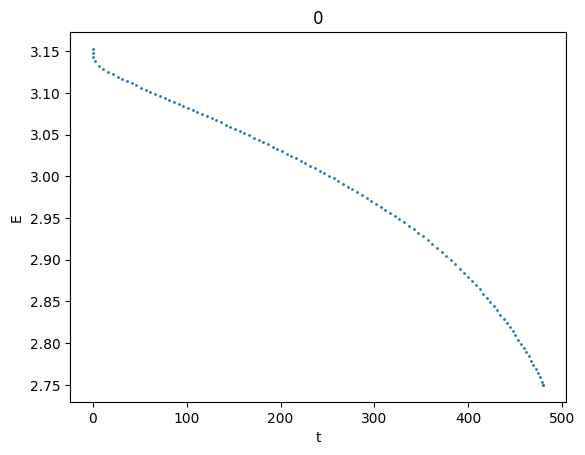

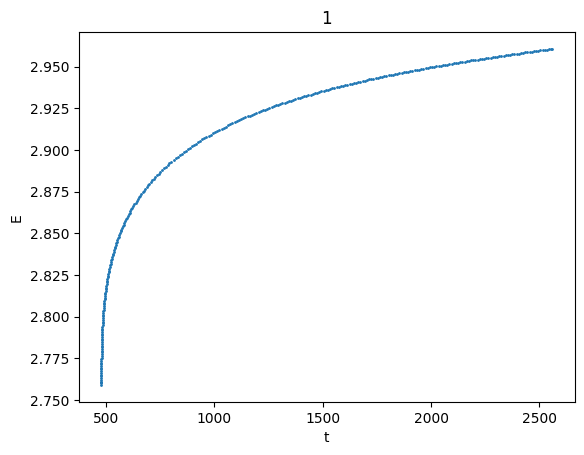

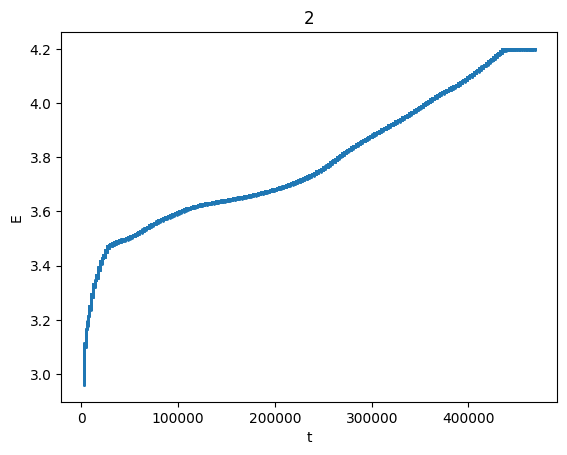

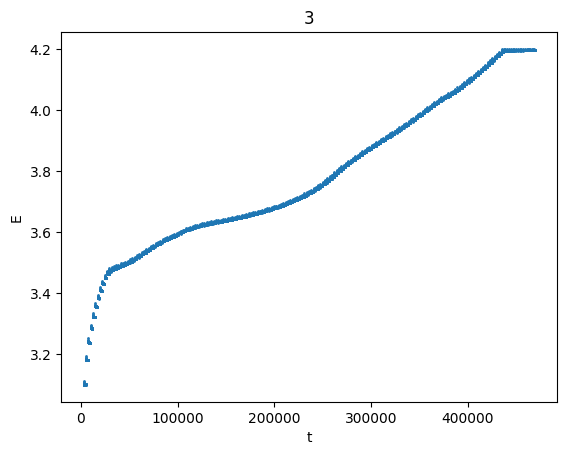

In [197]:
#Посмотреть на отдельные графики номера сиквенсов
ns_unique = raw_file['Ns'].unique()
for ns in ns_unique:
    raw_file[raw_file['Ns'] == ns].plot.scatter(x='t', y='E', s=1, title=str(ns), )

In [198]:
#Удаляем лишние последовательности

drop_ns = [0, 1]
raw_file.drop(raw_file[raw_file['Ns'].isin(drop_ns)].index, inplace=True)

In [199]:
# raw_file.drop(grouped.groups[317], inplace=True)

In [200]:
#Возможная коррекция времени
# time_correction = raw_files[0]['time/s'].max()
# raw_files[1]['time/s'] += time_correction
# raw_files[1]['Ns'] +=2
# merge_file = pd.concat(raw_file).reset_index()
# merge_file.plot(x='time/s',y='Ewe/V')

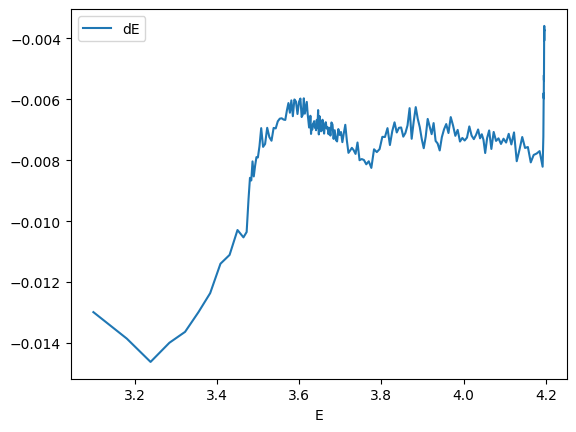

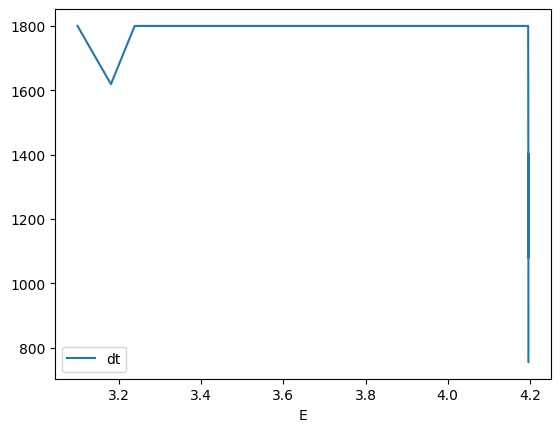

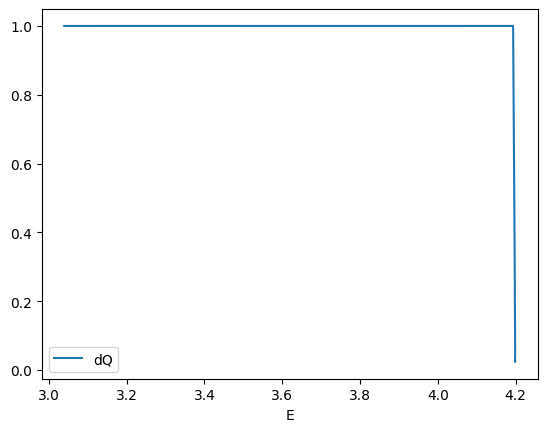

In [201]:
#Нарисовать графики, как оно выглядит.
grouped = group_sequences(raw_file)
diff = differ(raw_file)
plot_eDe(diff)
plot_dt(diff)
plot_dq(diff)

In [202]:
#Сделать дополнительные колонки
diff['Q'] = diff['dQ'].cumsum()
diff['E_min'] = grouped.min()['E']
diff['t_len'] = diff['dt'] / grouped['t'].count()
diff

,Ns,dt,dE,I,dQ,E,t,Q,E_min,t_len
Ns,,,,,,,,,,
1,2,599.951985,0.153395,5.999582,9.999003e-01,3.039820,2558.959135,0.999900,2.959788,3.703407
2,3,1799.951966,-0.012985,0.000000,-3.333667e-07,3.099358,3158.959320,0.999900,3.098416,9.889846
3,2,599.999993,0.091856,0.028581,9.999816e-01,3.152174,4958.911486,1.999882,3.100573,4.545454
4,3,1618.977980,-0.013854,0.000000,0.000000e+00,3.180662,5558.959679,1.999882,3.179333,9.871817
5,2,599.951993,0.073012,6.000154,9.998956e-01,3.219689,7177.986059,2.999777,3.178302,4.615015
...,...,...,...,...,...,...,...,...,...,...
398,3,1079.319196,-0.003592,0.000000,0.000000e+00,4.196298,465945.756172,182.453519,4.195989,9.902011
399,2,14.088189,0.004621,5.999263,2.347637e-02,4.198569,467025.123768,182.476996,4.195187,1.565354
400,3,1403.113755,-0.003730,0.000000,0.000000e+00,4.196283,467039.260357,182.476996,4.196046,9.881083


In [203]:
#Выбрать предел по ёмкости, полуциклы выше которых будут учитываться. Формирует путь для дальнейшего фита.
dq_limit = 0.5

charge_idx = diff[diff['dQ'] > dq_limit].index
rest_idx = charge_idx + 1
all_idx = charge_idx.append(rest_idx).sort_values()

In [204]:
#Сделать список из Q-E для простой кривой
q_final = diff.loc[charge_idx]['Q'].reset_index(drop=True)
simple_curve = pd.concat([q_final, diff.loc[rest_idx]['E_min'].reset_index(drop=True)], axis=1)
simple_curve

,Q,E_min
0,0.999900,3.098416
1,1.999882,3.179333
2,2.999777,3.236039
3,3.999758,3.281978
4,4.999740,3.320107
...,...,...
176,176.994574,4.161926
177,177.994512,4.169067
178,178.994454,4.176170
179,179.994395,4.183387


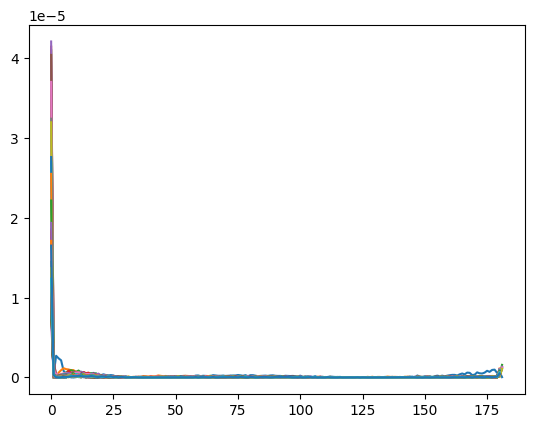

In [205]:
init = [0.01, 100, 3.8]
bounds = [[0, np.inf], [0, np.inf], [0, np.inf]]
bounds = np.array(bounds)
lbound = bounds[:, 0]
ubound = bounds[:, 1]
bounds = (lbound, ubound)
func_couple1 = [relax1, *init]
res1 = fit_e(raw_file, grouped, rest_idx, func_couple1, bounds=bounds)
r1_curve = pd.DataFrame(res1[:, -2], columns=['Exp1'])

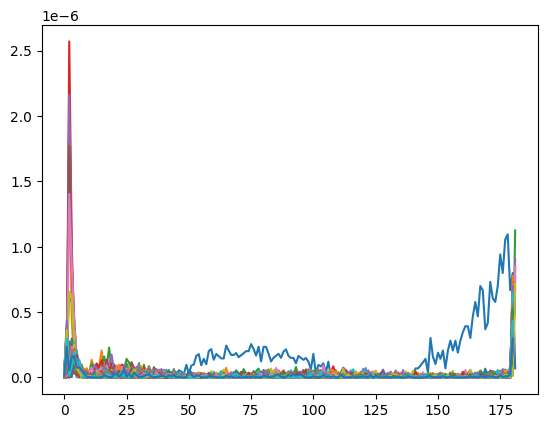

In [206]:
init = [0.01, 1, 0.05, 500, 3.7]
bounds = [[0, np.inf], [0, np.inf], [0, np.inf], [0, np.inf], [0, np.inf]]
bounds = np.array(bounds)
lbound = bounds[:, 0]
ubound = bounds[:, 1]
bounds = (lbound, ubound)
func_couple2 = [relax2, *init]
res2 = fit_e(raw_file, grouped, rest_idx, func_couple2, bounds=bounds)
r2_curve = pd.DataFrame(res2[:, -2], columns=['Exp2'])

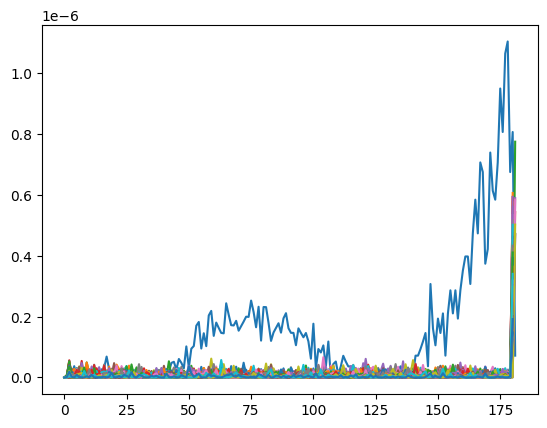

In [207]:
init = [0.01, 1, 0.03, 40, 0.02, 700, 3.8]
bounds = [[0, np.inf], [0, np.inf], [0, np.inf], [0, np.inf], [0, np.inf], [0, np.inf], [3, 6]]
bounds = np.array(bounds)
lbound = bounds[:, 0]
ubound = bounds[:, 1]
bounds = (lbound, ubound)
func_couple3 = [relax3, *init]
res3 = fit_e(raw_file, grouped, rest_idx, func_couple3, bounds=bounds)
r3_curve = pd.DataFrame(res3[:, -2], columns=['Exp3'])


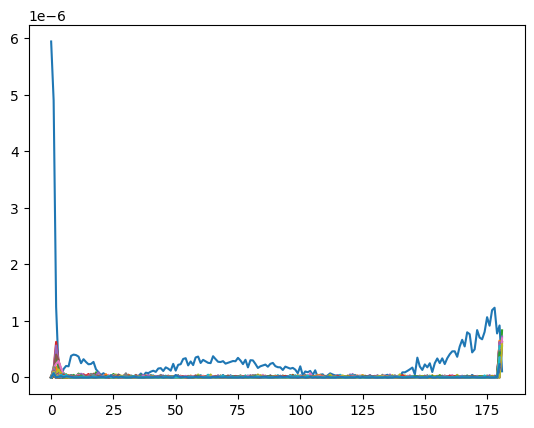

In [208]:
init = [12, 500, 500, 1000, 3.8]
bounds = [[0, np.inf], [0, np.inf], [0, np.inf], [0, np.inf], [0, np.inf]]
bounds = np.array(bounds)
lbound = bounds[:, 0]
ubound = bounds[:, 1]
bounds = (lbound, ubound)
func_couple_polynom = [relax_polynom, *init]
res_polynom = fit_e(raw_file, grouped, rest_idx, func_couple_polynom, bounds=bounds)
rpol_curve = pd.DataFrame(res_polynom[:, -2], columns=['Exp_pol'])


In [179]:
# init = [0.01, 0.01, 3.8]
# bounds = [[0, np.inf],[0, 2],[0, np.inf] ]
# bounds = np.array(bounds)
# lbound =bounds[:,0]
# ubound = bounds[:, 1]
# bounds = (lbound, ubound)
# func_couple_cotrell = [relax_cotrell, *init]
# res_cotrell = fit_e(raw_file, grouped, rest_idx, func_couple_cotrell, bounds=bounds)
# rcot_curve = pd.DataFrame(res_cotrell[:, -2], columns=['Exp_cotrell'])

<Axes: >

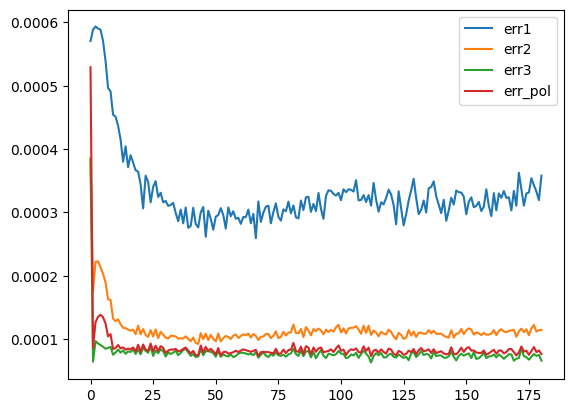

In [209]:
curves = pd.concat([simple_curve, r1_curve, r2_curve, r3_curve, rpol_curve, ], axis=1)
errors = pd.DataFrame(np.vstack([res1[:, -1], res2[:, -1], res3[:, -1], res_polynom[:, -1], ]).T,
                      columns=['err1', 'err2', 'err3', 'err_pol', ])
errors.plot()

<Axes: >

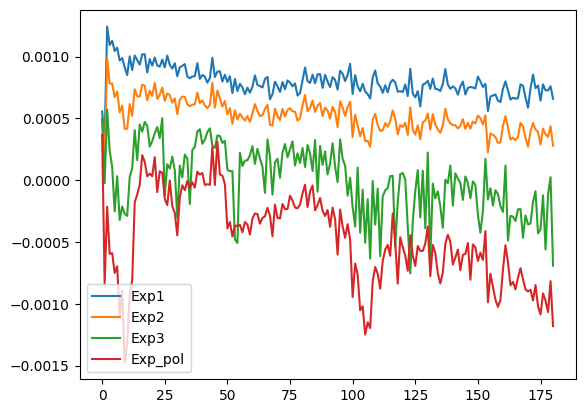

In [210]:
curves.iloc[:, [2, 3, 4, 5]].sub(curves['E_min'], axis=0).plot()

<Axes: >

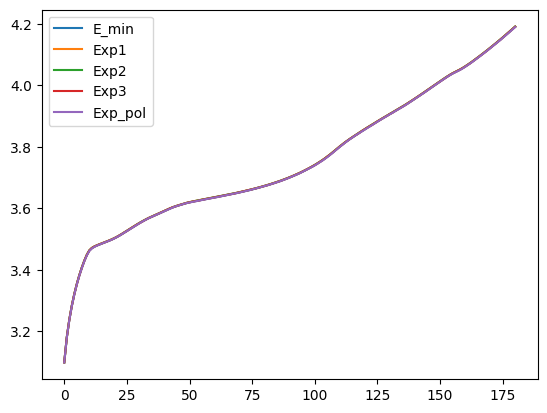

In [211]:
curves.iloc[:, [1, 2, 3, 4, 5]].plot()

In [212]:
filename

'2024 01 18 G46 refilled gitt dva mid_C07.mpt'

In [213]:
#Сохранение результатов, указать папку и название файлов
dir_path = filedir
save_name = 'G46 OCV 8.2 better init or exp3'
file_path_data = os.path.join(dir_path, save_name + '_apr.csv')
errors_path = os.path.join(dir_path, save_name + '_err.csv')
curves.to_csv(file_path_data)
errors.to_csv(errors_path)